## Unsupervised adversarial attack detection in autoencoders activations and Reconstruction Error with Subset Scanning
In this jupyter notebook we will show how subset scanning is used to analize reconstruction error and activations over autoencoders layers. From loading the module, runing subset scanning and visualizing the outputs.


#### Load model to extract layers names and filter by activation


In [ ]:
from keras.models import load_model

# We upload autoencoders for both datasets and trained with 
# different % of noised samples
ae_mnist = load_model('models/fmnist_autoencoder.h5')
ae_mnist.summary()

In [2]:
activation_layers = [layer.name for layer in ae_mnist.layers]
activation_layers

['input_1',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'conv2d_4',
 'up_sampling2d_1',
 'conv2d_5',
 'up_sampling2d_2',
 'conv2d_6',
 'up_sampling2d_3',
 'conv2d_7']

### Run ss over clean and anomalous data and save output files related to activation

In [70]:
# avoid first one is input image
for activation in activation_layers[1:]:
    print('Run SSE for layer {}'.format(activation))
    !python main.py --clean_ssize 1 --anom_ssize 0 --bgddata ../ICLR/data/fmnist_bg_7000.npy --cleandata ../ICLR/data/fmnist_clean_1500.npy --anomdata ../ICLR/data/np_fmnist_df_cnn_keras.npy --model ../ICLR/models/fmnist_autoencoder.h5 --layers {activation}  --resultsfile ../ICLR/results/fmnist_clean_{activation}.out
    !python main.py --clean_ssize 0 --anom_ssize 1 --bgddata ../ICLR/data/fmnist_bg_7000.npy --cleandata ../ICLR/data/fmnist_clean_1500.npy --anomdata ../ICLR/data/np_fmnist_df_cnn_keras.npy --model ../ICLR/models/fmnist_autoencoder.h5 --layers {activation}  --resultsfile ../ICLR/results/fmnist_df_{activation}.out

Run SSE for layer conv2d_1
Using TensorFlow backend.
//////////////////////////////
Loading Model and data sets...
//////////////////////////////
2019-09-23 02:13:49.173729: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
//////////////////////////////
Extracting background activations...
//////////////////////////////
is cached
//////////////////////////////
Extracting clean activations...
//////////////////////////////
is cached
//////////////////////////////
Extracting anomalous activations...
//////////////////////////////
is cached
//////////////////////////////
Calculating pvalues...
//////////////////////////////
//////////////////////////////
Creating test sets...
//////////////////////////////
Beginning Scanning...
100%|#####################################| 1500/1500 [00:00<00:00, 2158.27it/s]
Writing Hyperparamters to file...
Using TensorFlow backend.
///////////////////////////

//////////////////////////////
Extracting clean activations...
//////////////////////////////
is cached
//////////////////////////////
Extracting anomalous activations...
//////////////////////////////
is cached
//////////////////////////////
Calculating pvalues...
//////////////////////////////
//////////////////////////////
Creating test sets...
//////////////////////////////
Beginning Scanning...
100%|####################################| 1500/1500 [00:00<00:00, 10568.83it/s]
Writing Hyperparamters to file...
Using TensorFlow backend.
//////////////////////////////
Loading Model and data sets...
//////////////////////////////
2019-09-23 02:15:14.260282: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
//////////////////////////////
Extracting background activations...
//////////////////////////////
is cached
//////////////////////////////
Extracting clean activations...
/////////////////

//////////////////////////////
Extracting background activations...
//////////////////////////////
is cached
//////////////////////////////
Extracting clean activations...
//////////////////////////////
is cached
//////////////////////////////
Extracting anomalous activations...
//////////////////////////////
is cached
//////////////////////////////
Calculating pvalues...
//////////////////////////////
//////////////////////////////
Creating test sets...
//////////////////////////////
Beginning Scanning...
100%|####################################| 1159/1159 [00:00<00:00, 11246.21it/s]
Writing Hyperparamters to file...
Run SSE for layer up_sampling2d_2
Using TensorFlow backend.
//////////////////////////////
Loading Model and data sets...
//////////////////////////////
2019-09-23 02:15:52.636186: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
//////////////////////////////
Extracting back

### Load output files from subset scanning and visualize

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import importlib

def load_results(clean_fn='results/reconstruction_error/mnist_clean_conv2d_7.out',
                 fake_fn='results/reconstruction_error/mnist_bim_conv2d_7.out'):
    resultselector = ResultSelector(score=True)
    a = ResultParser.get_results(clean_fn, resultselector)
    b = ResultParser.get_results(fake_fn, resultselector)
    clean_scores = np.array(a['scores'])
    anom_scores =  np.array(b['scores'])
    
    return clean_scores, anom_scores

In [ ]:
from ipywidgets import widgets
import seaborn as sns
from sklearn import metrics
import numpy as np
import os
from util.resultparser import ResultParser, ResultSelector

plt.rcParams.update({'font.size': 11})

def plot_layer(activation_layers, model='mnist_autoencoder.h5'):
    """get name of layer and load subset scores from BIM attacks and 
    clean images and display score distribution and AUC"""
    print(activation_layers)
    clean_scores, anom_scores = load_results(clean_fn=\
                                              '/tmp/ICLR/results/fmnist_clean_{}.out'.format(
                                              str(activation_layers)), 
                                              fake_fn=\
                                              '/tmp/ICLR/results/fmnist_df_{}.out'.format(
                                              str(activation_layers)))
    
    sns.kdeplot(clean_scores, shade=True, label='clean data')
    sns.kdeplot(anom_scores, shade=True, label='noised data')
    plt.title('Distribution of Subset Scores for layer {}'.format(str(activation_layers)))
    #plt.title('Distribution of Subset Scores for Reconstruction Error')
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel('Subset Score')
    y_true = np.append([np.ones(len(anom_scores))], [np.zeros(len(clean_scores))])
    all_scores = np.append([anom_scores], [clean_scores])

    fpr, tpr, thresholds = metrics.roc_curve(y_true, all_scores)
    roc_auc = metrics.auc(fpr, tpr)
    print(roc_auc)
    plt.show()
    
widgets.interact(plot_layer, activation_layers=activation_layers[1:], layer_number=\
                 widgets.IntSlider(min=1, max=len(activation_layers)-1, step=1, value=len(activation_layers)-1))

### Run subset scanning individually with BIM adversarial noise method over reconstruction error (per pixel)
$28 \times 28$ node space

In [198]:
!python main.py --clean_ssize 1 --anom_ssize 0 --bgddata ../ICLR/data/fmnist_bg_7000.npy --cleandata ../ICLR/data/fmnist_clean_1500.npy --anomdata ../ICLR/data/fmnist_class_9.npy --model ../ICLR/models/fmnist_autoencoder_9compl.h5 --layers {activation_layers[-1]} --run 500 --restarts 1 --customfunction reconstructiondiff --resultsfile ../ICLR/results/fmnist_clean_{activation_layers[-1]}_recerror.out
!python main.py --clean_ssize 0 --anom_ssize 1 --bgddata ../ICLR/data/fmnist_bg_7000.npy --cleandata ../ICLR/data/fmnist_clean_1500.npy --anomdata ../ICLR/data/fmnist_class_9.npy --model ../ICLR/models/fmnist_autoencoder_9compl.h5 --layers {activation_layers[-1]} --run 500 --restarts 1 --customfunction reconstructiondiff --resultsfile ../ICLR/results/fmnist_outdist_{activation_layers[-1]}_recerror.out

Using TensorFlow backend.
//////////////////////////////
Loading Model and data sets...
//////////////////////////////
2019-09-16 07:18:27.702538: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
//////////////////////////////
Extracting background activations...
//////////////////////////////
writing to cache
//////////////////////////////
Extracting clean activations...
//////////////////////////////
writing to cache
//////////////////////////////
Extracting anomalous activations...
//////////////////////////////
writing to cache
//////////////////////////////
Calculating pvalues...
//////////////////////////////
//////////////////////////////
Creating test sets...
//////////////////////////////
Beginning Scanning...
100%|#####################################| 1500/1500 [00:00<00:00, 6937.13it/s]
Writing Hyperparamters to file...
Using TensorFlow backend.
//////////////////////////////
Lo

### Visualization of subset scores distributions for clean and noised samples

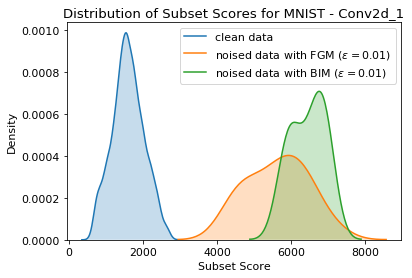

In [203]:
import aux_exp
import importlib
importlib.reload(aux_exp)

from aux_exp import draw_paper_plot_dist_scores
    
draw_paper_plot_dist_scores(clean_fn='../ICLR/results/mnist_clean_conv2d_1.out',
                            fake_fn_bim='../ICLR/results/mnist_bim_conv2d_1.out',
                            fake_fn_fgm='../ICLR/results/mnist_fgm_conv2d_1.out',
                            path='../ICLR/figures/mnist_density_scores_conv_1.png',
                            dataset='MNIST - Conv2d_1')

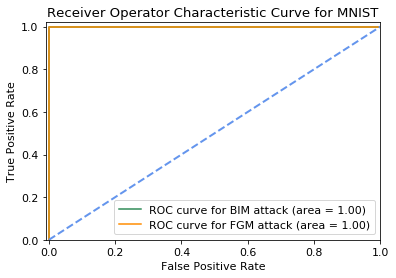

In [201]:
from  aux_exp import draw_paper_plot_auc_scores

clean_scores, anom_scores_bim = load_results(clean_fn='../ICLR/results/mnist_clean_conv2d_1.out',
                                             fake_fn='../ICLR/results/mnist_bim_conv2d_1.out')
clean_scores, anom_scores_fg = load_results(clean_fn='../ICLR/results/mnist_clean_conv2d_1.out',
                                             fake_fn='../ICLR/results/mnist_fgm_conv2d_1.out')

draw_paper_plot_auc_scores(clean_scores, anom_scores_bim, anom_scores_fg,
                           path='../ICLR/figures/ROC_MNIST_AE_conv2d_1.png',
                          dataset='MNIST')

### Check reconstruction errors for noised and clean images

In [36]:
from util.activation_extractor import KerasActivationExtractor
from aux_exp import getReconstructionErrFunction

extractor = KerasActivationExtractor('../ICLR/models/mnist_autoencoder.h5', [activation_layers[7]], False)
reconstruction_error = getReconstructionErrFunction('../ICLR/data/mnist_clean_1500.npy')
clean_act = extractor.extract_activation('../ICLR/data/mnist_bg_7000.npy', reconstruction_error)

is cached


In [391]:
extractor = KerasActivationExtractor('../ICLR/models/mnist_autoencoder.h5', [activation_layers[7]], False)
reconstruction_error_bim = getReconstructionErrFunction('../ICLR/data/np_mnist_df_cnn_keras.npy')
bim_act = extractor.extract_activation('../ICLR/data/mnist_clean_1500.npy', reconstruction_error_bim)

is cached


### Plot mean and max reconstruction error from clean and noise samples to use as baseline and calculate AUC

0.5747649496743635


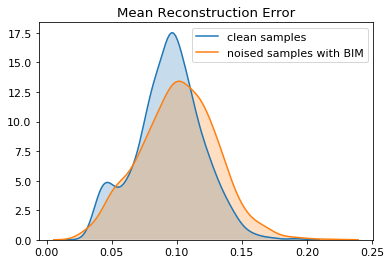

In [186]:
sns.kdeplot(np.mean(clean_act[0], axis=1), shade=True, label='clean samples')
sns.kdeplot(np.mean(bim_act[0], axis=1), shade=True, label='noised samples with BIM')
plt.title('Mean Reconstruction Error')
plt.legend()
clean_scores = np.mean(clean_act[0], axis=1)
anom_scores = np.mean(bim_act[0], axis=1)
y_true = np.append([np.ones(len(anom_scores))], [np.zeros(len(clean_scores))])
all_scores = np.append([anom_scores], [clean_scores])

fpr, tpr, thresholds = metrics.roc_curve(y_true, all_scores)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

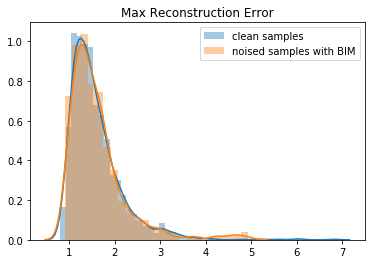

In [35]:
sns.distplot(np.max(clean_act[0], axis=1), label='clean samples')
sns.distplot(np.max(bim_act[0], axis=1), label='noised samples with BIM')
plt.title('Max Reconstruction Error')
plt.legend()

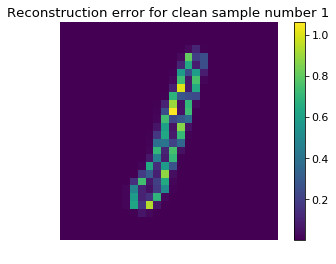

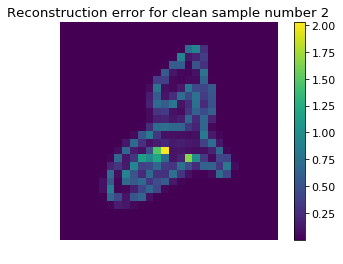

In [145]:
for i,n in zip(range(2), [1, 2]):
    plt.title('Reconstruction error for clean sample number {}'.format(n))
    plt.imshow(clean_act[0][i].reshape(28, 28))
    plt.colorbar()
    plt.axis('off')
    plt.show()

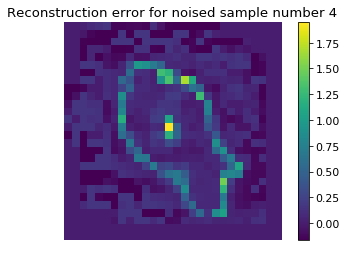

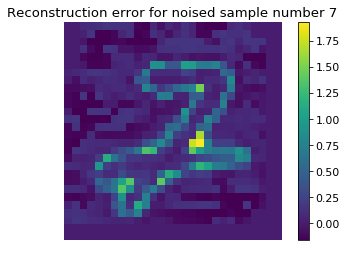

In [148]:
for i,n in zip(range(2), [4, 7]):
    plt.title('Reconstruction error for noised sample number {}'.format(n))
    plt.imshow(bim_act[0][i].reshape(28, 28))
    plt.colorbar()
    plt.axis('off')
    plt.show()

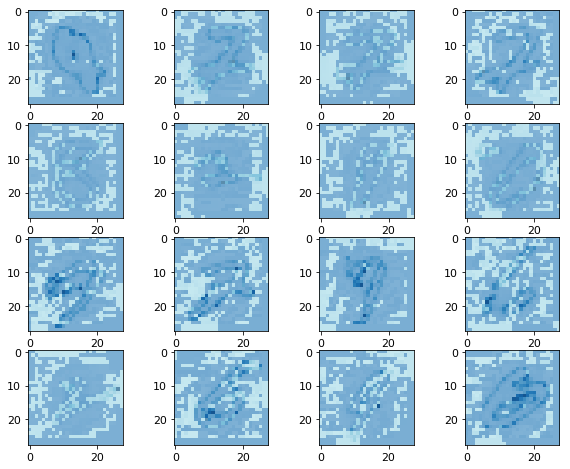

In [150]:
from aux_exp import get_anom_nodes

nodes = get_anom_nodes(fn='../ICLR/results/mnist_bim_conv2d_7_recerror.out')

n_row = 4
n_col = 4

plt.figure(figsize=(10, 8))
for i in list(range(n_row * n_col)):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(bim_act[0][i].reshape(28, 28), cmap='Blues')
    zeros = np.zeros((784))
    np.put(zeros, nodes[i], 5.)
    plt.imshow(zeros.reshape(28, 28), cmap='tab20', alpha=0.55)
plt.show()

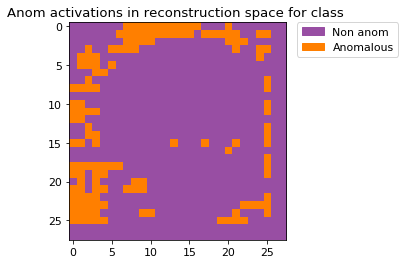

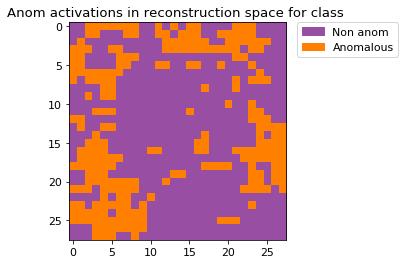

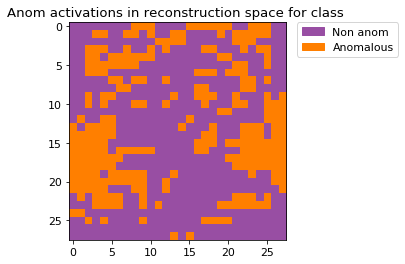

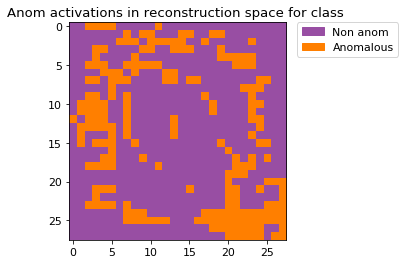

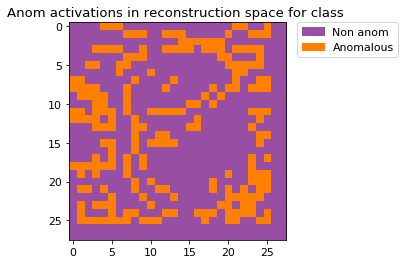

In [151]:
from aux_exp import draw_anoms, get_anom_nodes

nodes = get_anom_nodes(fn='../ICLR/results/mnist_bim_conv2d_7_recerror.out')
for node in nodes[:5]:
    draw_anoms(node)